In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import copy
from sklearn.preprocessing import normalize
from sklearn.isotonic import IsotonicRegression
from betacal import BetaCalibration

from helpers.plot_helpers import (set_up_3d_fig,
                                       draw_classic_arrow,
                                       add_triangle_axis,
                                       plot_ax_to_triangle_guidelines,
                                       plot_on_triangle_guidelines,
                                       generate_points_on_triangle,
                                       scatter_color_points_on_triangle)
from helpers.binnings import EqualWidthBinning
from helpers.temp_scaling import softmax
from helpers.proper_losses import log_loss, bs
from helpers.multiclass_data_generation import generate_data
from helpers.weighting_calibrators import (dirichlet_log_kernel,
                                           rbf_kernel,
                                           force_p_to_simplex,
                                           calibrate_preds_with_weighting,
                                           k_closest_uniform,
                                           minkowski_dist,
                                           proportional_to_exp_kernel)
from helpers.temp_scaling import TemperatureScaling
from helpers.dir_scaling import Dirichlet_NN
from helpers.vec_scaling import VectorScaling
from helpers.calibration_trees import RandomSplitCalibrationForest
from helpers import config

# Diff ways to take expectation

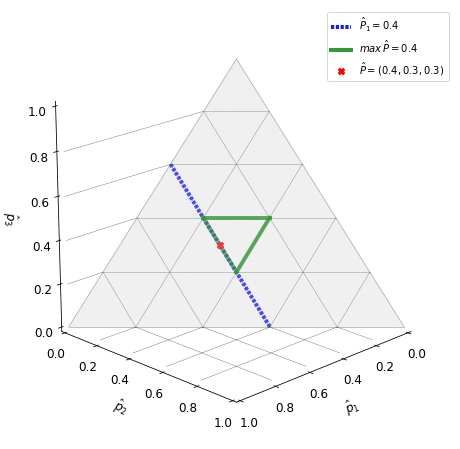

In [2]:
temp = 1
fig = set_up_3d_fig(subplots=1)
ax1, axis_idx = add_triangle_axis(fig, 1, 1, temp_param=temp, step=0.2)
plot_ax_to_triangle_guidelines(ax1, step=0.2)
plot_on_triangle_guidelines(ax1, thick_borders=False, temp_param=temp, step=0.2, zorder=0)

multi_points = np.array([[0.4, 0.3, 0.3]])

points = generate_points_on_triangle()
ax1.scatter(points[:, 0],
            points[:, 1],
            points[:, 2],
            alpha=0.14, c="lightgray", s=1.5, zorder=0)

ax1.scatter(multi_points[:, 0],
            multi_points[:, 1],
            multi_points[:, 2],
            alpha=1, c="red", s=40, zorder=3, marker="X", label="$\hat{P}=(0.4, 0.3, 0.3)$")

ax1.plot([0.4, 0.4], [0, 0.6], [0.6, 0], color="blue", alpha=0.9, lw=4, zorder=1, label="$\hat{P}_1=0.4$",
         linestyle=(0, (0.8, 0.4)))

ax1.plot([0.4, 0.4], [0.2, 0.4], [0.4, 0.2], color="green", alpha=0.6, lw=4, zorder=1)
ax1.plot([0.2, 0.4], [0.4, 0.4], [0.4, 0.2], color="green", alpha=0.8, lw=4, zorder=1)
ax1.plot([0.2, 0.4], [0.4, 0.2], [0.4, 0.4], color="green", alpha=0.8, lw=4, zorder=1, label="$max\,\hat{P}=0.4$")

plt.legend()
plt.savefig("figures/expectation_diff.jpg", dpi=400, bbox_inches="tight")
plt.show()

# Assumption difference 

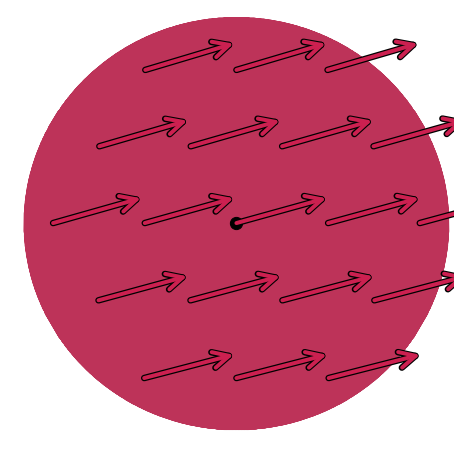

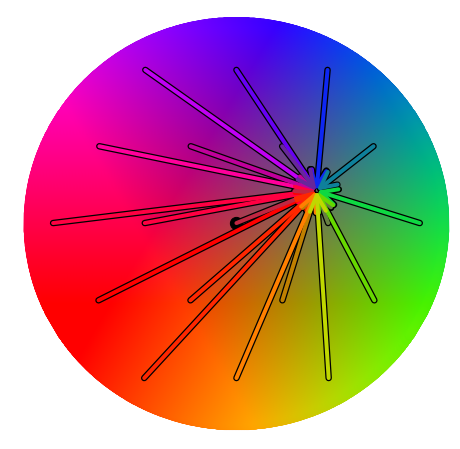

In [3]:
c_point = [0.30, 0.38, 0.365]


def assumption_f1(p):
    cal = np.copy(p)
    ce = c_point - np.array([0.34, 0.33, 0.34])  # 0.22, 0.4, 0.38
    cal[np.sum((p - [0.35, 0.35, 0.35]) ** 2, axis=1) < 0.023] = cal[np.sum((p - [0.35, 0.35, 0.35]) ** 2,
                                                                            axis=1) < 0.023] + ce
    return cal


def assumption_f2(p):
    cal = np.copy(p)
    cal[np.sum((p - [0.35, 0.35, 0.35]) ** 2, axis=1) < 0.023] = c_point
    return cal


assumption_funs = [assumption_f1, assumption_f2]
titles = ["p-y_assumption", "y_assumption"]
color_intensity = 6

for f_idx in range(2):
    # fig
    fig = set_up_3d_fig(subplots=1)
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.set_ylim(0.265, 0.435)
    ax.set_xlim(0.265, 0.435)
    ax.set_zlim(0.265, 0.435)
    ax.set_axis_off()
    ax.view_init(elev=30, azim=45)

    # center point
    ax.scatter([0.75],
               [0.75],
               [0.6745],
               alpha=1, c="black", s=150)

    # Arrows
    arrow_starts = generate_points_on_triangle(step_size=(1 - 0.02375 * 3) / 20, rounding_to=7,
                                               start=0.055)
    arrow_ends = assumption_funs[f_idx](arrow_starts)
    arrow_ends_black = arrow_ends + 0.003 * normalize(arrow_ends - arrow_starts, "l1")

    for idx in range(len(arrow_starts)):
        draw_classic_arrow(arrow_starts[idx], arrow_ends_black[idx], ax=ax, alpha=1,
                           color="black", lw=6.5, mutation_scale=40)

    for idx in range(len(arrow_starts)):
        draw_classic_arrow(arrow_starts[idx], arrow_ends[idx], ax=ax, alpha=1, lw=4,
                           color=np.clip(((arrow_starts[idx] - arrow_ends[idx]) * (color_intensity + 1.5) + 0.5),
                                         a_min=0,
                                         a_max=1), mutation_scale=40)

    # points
    points = generate_points_on_triangle(step_size=0.0003, start=0.1, rounding_to=6)
    points[points == 0] = 1e-5
    cal_points = assumption_funs[f_idx](points)
    CE_estimates = np.clip(((points - cal_points) * color_intensity + 0.5), a_min=0,
                           a_max=1)
    CE_estimates = CE_estimates[((points - cal_points)[:, 0] != 0) & ((points - cal_points)[:, 1] != 0)]
    points = points[((points - cal_points)[:, 0] != 0) & ((points - cal_points)[:, 1] != 0)]

    cmap = copy.copy(plt.get_cmap('YlOrRd'))
    #scatter_points = ax.scatter(points[:, 0],
    #                            points[:, 1],
    #                            points[:, 2],
     #                           alpha=1, c=CE_estimates, s=85, zorder=1, cmap=cmap, norm=None, rasterize=True)
    #
    ###
    cmap = copy.copy(plt.get_cmap('YlOrRd'))

    points = np.array(points)
    colors = np.array(CE_estimates)

    if len(colors.shape) == 1:
        colors = np.ma.masked_where(colors == 0, colors)

    scatter_points = ax.scatter(points[:, 0],
                                points[:, 1],
                                points[:, 2],
                                alpha=1, c=colors, s=85, zorder=1, cmap=cmap, norm=None, rasterized=True)
    
    ##
    #
    plt.savefig(f"figures/{titles[f_idx]}.jpg", dpi=400, bbox_inches="tight")
    plt.show()

# Cost matrix

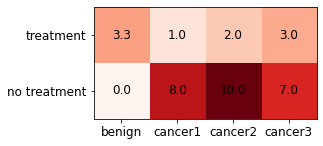

In [4]:
cost_matrix = np.array([[3.3, 1, 2, 3],
                        [0, 8, 10, 7]])

fig, ax = plt.subplots(nrows=1, figsize=(4, 4),
                       )

im = ax.imshow(cost_matrix, cmap=plt.cm.get_cmap('Reds'))

# Loop over data dimensions and create text annotations.
for i in range(2):
    for j in range(4):
        text = ax.text(j, i, cost_matrix[i, j],
                       ha="center", va="center", color="black", fontsize=12)

ax.set_yticks([0, 1])
ax.set_yticklabels(["treatment", "no treatment"], fontsize=12)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(["benign", "cancer1", "cancer2", "cancer3"], fontsize=12)
plt.savefig(f"figures/loss_function.pdf", dpi=400, bbox_inches="tight")
plt.show()

# Create true calibration map from ResNet-110 logits on CIFAR-5m 

In [5]:
def draw_cf_triangle(cal_fun, title, name=None, color_intensity=3.5, n_arrows=20, colorful_arrows=True, dpi=400):
    print(title)
    if name == None:
        name = title

    # True CE
    cal_p_test = cal_fun(data_test["p"])
    true_ce = np.round(np.mean(np.abs(cal_p_test - data_test['c'])), 7)
    print(f"True multiclass mean absolute CE: {true_ce}")

    # Fig
    fig = set_up_3d_fig(subplots=1)
    ax1, axis_idx = add_triangle_axis(fig, 1, 1, temp_param=1, step=0.2)
    
    #
    #plot_ax_to_triangle_guidelines(ax1, step=0.2)
    alpha = 0.5
    lw = 0.5
    zorder = 20
    for i in np.arange(0, 1, 0.2):
        ax1.plot([i, i], [1, 1 - i], [0, 0], color="black", alpha=alpha, lw=lw, zorder=zorder, rasterized=True)
        ax1.plot([1, 1 - i], [i, i], [0, 0], color="black", alpha=alpha, lw=lw, zorder=zorder, rasterized=True)
        ax1.plot([1, 1 - i], [0, 0], [i, i], color="black", alpha=alpha, lw=lw, zorder=zorder, rasterized=True)
    
    #plot_on_triangle_guidelines(ax1, thick_borders=False, temp_param=1, step=0.2)
    
    #
    
    for i in np.arange(0, 1, 0.2):
        ax1.plot([0, 1 - i], [1 - i, 0], [i, i], color="black", alpha=alpha, lw=lw, zorder=zorder, rasterized=True)
        ax1.plot([i, i], [1 - i, 0], [0, 1 - i], color="black", alpha=alpha, lw=lw, zorder=zorder, rasterized=True)
        ax1.plot([0, 1 - i], [i, i], [1 - i, 0], color="black", alpha=alpha, lw=lw, zorder=zorder, rasterized=True)

    # Arrows
    arrow_starts = generate_points_on_triangle(step_size=(1 - 0.02375 * 3) / n_arrows, rounding_to=7,
                                               start=0.02375)
    arrow_ends = cal_fun(arrow_starts)

    if colorful_arrows:
        arrow_ends_black = arrow_ends + 0.007 * normalize(arrow_ends - arrow_starts, "l1")

        for idx in range(len(arrow_starts)):
            draw_classic_arrow(arrow_starts[idx], arrow_ends_black[idx], ax=ax1, alpha=0.4,
                               color="black", lw=1.7)

        for idx in range(len(arrow_starts)):
            draw_classic_arrow(arrow_starts[idx], arrow_ends[idx], ax=ax1, alpha=1, lw=0.6,
                               color=np.clip(((arrow_starts[idx] - arrow_ends[idx]) * (color_intensity + 1.5) + 0.5),
                                             a_min=0,
                                             a_max=1))
    else:
        for idx in range(len(arrow_starts)):
            draw_classic_arrow(arrow_starts[idx], arrow_ends[idx], ax=ax1, alpha=0.8,
                               color="black", lw=0.5)

    points = generate_points_on_triangle(step_size=0.0025, rounding_to=4)
    #points[points == 0] = 1e-8
    points = points[points[:,0] > 0]
    points = points[points[:,1] > 0]
    points[points == 0] = 1e-8
    
    cal_points = cal_fun(points)
    CE_estimates = np.clip(((points - cal_points) * color_intensity + 0.55), a_min=0,
                           a_max=1)
    #sc = scatter_color_points_on_triangle(ax1, points=points, colors=CE_estimates, use_log_colors=False,
    #                                      alpha=0.6)
    
    ###
    cmap = copy.copy(plt.get_cmap('YlOrRd'))

    norm = None

    points = np.array(points)
    colors = np.array(CE_estimates)

    if len(colors.shape) == 1:
        colors = np.ma.masked_where(colors == 0, colors)

    scatter_points = ax1.scatter(points[:, 0],
                                points[:, 1],
                                points[:, 2],
                                alpha=1, c=colors, s=0.25, zorder=1, cmap=cmap, norm=norm, rasterized=True, marker="o")
    
    ##
    
    plt.title(title)
    plt.savefig("figures/" + name + ".pdf", dpi=dpi, bbox_inches="tight", transparent=True)
    plt.show()

figs_dpi = 300

In [6]:
def read_data(path=config.CIFAR5M_LOGIT_DIR + "/"):

    X = []
    Y = []

    for i, file in enumerate(os.listdir(path)):
        with open(path + file, "rb") as f:
            x_part, y_part = np.load(f, allow_pickle=True)
            X.append(x_part)
            Y.append(y_part)

    Y = np.concatenate(Y)
    X = np.concatenate(X)

    probs = softmax(X)
    preds = np.argmax(probs, axis=1)

    return (probs, preds, Y, X)

probs, preds, Y, logits = read_data()
y = np.eye(10)[Y]

ts = TemperatureScaling()
ts.fit(logits[:10**4], y.argmax(axis=1)[:10**4])
print(ts.temp)

# Divide by temp 2.3
probs = softmax(logits / 2.3)

# airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, trucks
g0_idx = [0,1,2,3]
g1_idx = [4,5,6]
g2_idx = [7,8,9]

# Group 
cifar5m_y = np.dstack((np.sum(y[:, g0_idx], axis=1),
                       np.sum(y[:, g1_idx], axis=1),
                       np.sum(y[:, g2_idx], axis=1)))[0]
cifar5m_p = np.dstack((np.sum(probs[:, g0_idx], axis=1),
                           np.sum(probs[:, g1_idx], axis=1),
                           np.sum(probs[:, g2_idx], axis=1)))[0]

# Learn true cal map
forest_true = RandomSplitCalibrationForest(n_trees=250, depth=9, n_classes=3)
forest_true.fit(p=cifar5m_p[:5*10**6], y=cifar5m_y[:5*10**6])

def true_cal_fun(p):
    return forest_true.calibrate_predictions(p)

# Generate data with true cal map
dirichlet = [0.5, 0.5, 0.5]
n_train = 5000
n_test = 100_000
temp = 1
data_train = generate_data(dirichlet, n_train, true_cal_fun, random_seed=1)
data_test = generate_data(dirichlet, n_test, true_cal_fun, random_seed=2)

3.0309630027657937


True calibration map
True multiclass mean absolute CE: 0.0


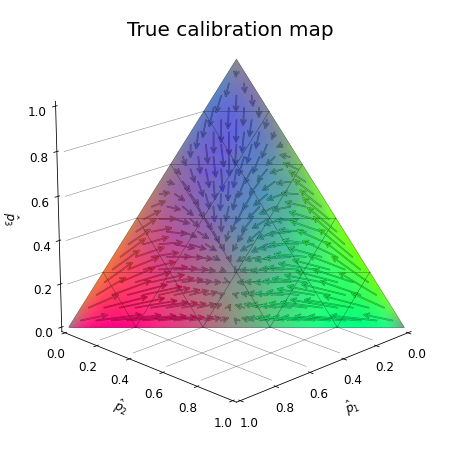

In [7]:
draw_cf_triangle(true_cal_fun, title="True calibration map", name=f"True calibration map", dpi=figs_dpi)

# Synthetic calibration data distribution

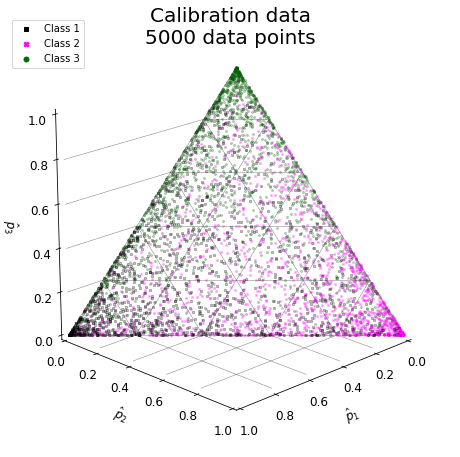

In [8]:
fig = set_up_3d_fig(subplots=1)
ax1, axis_idx = add_triangle_axis(fig, 1, 1, step=0.2)
plot_ax_to_triangle_guidelines(ax1, step=0.2)
plot_on_triangle_guidelines(ax1, thick_borders=False, step=0.2)

p = data_train["p"]
y = data_train["y"]

markers = ["s", "X", "o"]
colors = ["black", "magenta", "darkgreen"]
for idx in range(len(p)):
    ax1.scatter([p[idx, 0]], [p[idx, 1]], [p[idx, 2]], alpha=0.25, s=4, marker=markers[y[idx].argmax()],
                color=colors[y[idx].argmax()])

#for c in [0,1,2]:
#    idx = y.argmax(axis=1) == c
#    ax1.scatter(p[idx, 0], p[idx, 1], p[idx, 2], alpha=0.25, s=4, marker=markers[c], color=colors[c], label=colors[c])
idx = 0

ax1.scatter(p[idx, 0], p[idx, 1], 12, alpha=1, s=24, marker=markers[0], color=colors[0],
            label="Class 1")
ax1.scatter(p[idx, 0], p[idx, 1], 12, alpha=1, s=24, marker=markers[1], color=colors[1],
            label="Class 2")
ax1.scatter(p[idx, 0], p[idx, 1], 12, alpha=1, s=24, marker=markers[2], color=colors[2],
            label="Class 3")

ax1.legend(loc=2)
plt.title(f"Calibration data\n{n_train} data points")
plt.savefig("figures/3d_example_data.png", dpi=figs_dpi, bbox_inches="tight", transparent=True)
plt.show()

# Reliability diagram

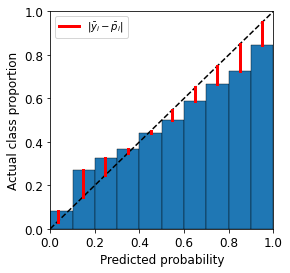

In [9]:
p = data_train["p"][:, 0]
y = data_train["y"][:, 0]
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

binning = EqualWidthBinning(p, y, c=None, n_bins=10)
# Bars
polygons = binning.construct_plt_polygons_flat()
for poly in polygons:
    poly.set_alpha(1)
    ax.add_patch(poly)
plt.plot([0, 1], [0, 1], "--", color="black")

for i in range(binning.n_bins):
    mean_p = np.mean(binning.binned_p[i])
    mean_y = np.mean(binning.binned_y[i])
    ax.plot([mean_p, mean_p], [mean_y, mean_p], '-', linewidth=3, color="red")

ax.plot([mean_p, mean_p], [mean_y, mean_p], '-', linewidth=3, color="red", label="$|\\bar{y}_i-\\bar{p}_i|$")

plt.legend()

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel("Predicted probability")
plt.ylabel("Actual class proportion")
plt.savefig("figures/rel_diag_example.pdf", dpi=400, bbox_inches="tight")

plt.show()

# Isotonic, histogram, Beta cal binary

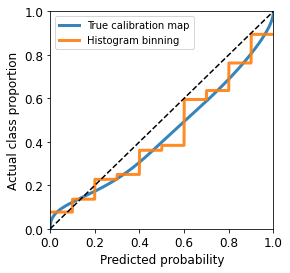

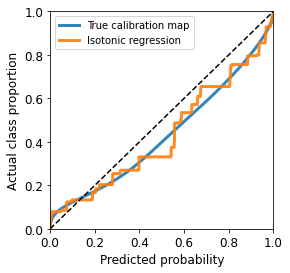

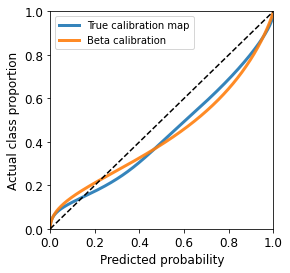

In [10]:
def true_cal_fun2d(p):
    def beta1(x):
        m = 0.45  
        a = 0.44 
        b = 0.47 
        c = b * np.log(1 - m) - a * np.log(m)
        return 1 / (1 + 1 / (np.exp(c) * (x ** a / (1 - x) ** b)))

    p1 = 0.4 * beta1(p[:, 0]) + 0.5 * p[:, 0] ** 2 + 0.1 * 1 / (1 + np.e ** (-12 * (p[:, 0] - 0.45)))
    p2 = 1 - p1
    return np.dstack([p1, p2])[0]

np.random.seed(0)
p = np.random.dirichlet([0.5, 0.5], 3000)
c = true_cal_fun2d(p)
c = c / np.sum(c, axis=1).reshape(-1, 1)
y = np.array([np.random.choice(np.arange(0, 2), p=pred) for pred in c])
y = np.eye(3)[y]

p = p[:, 0]
c = c[:, 0]
y = y[:, 0]
x = np.linspace(0, 1, 1000)

binning = EqualWidthBinning(p, y, c=None, n_bins=10)
pred_hist = binning.eval_flat(x)
ir = IsotonicRegression(out_of_bounds='clip')
y_ = ir.fit_transform(p, y)
pred_ir = ir.predict(x)
bc = BetaCalibration(parameters="abm")
bc.fit(p, y)
pred_bc = bc.predict(x)

preds = [pred_hist, pred_ir, pred_bc]
titles = ["Histogram binning", "Isotonic regression", "Beta calibration"]
for i in range(3):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    plt.plot(x, true_cal_fun2d(np.dstack([x, 1 - x])[0])[:, 0], label="True calibration map", lw=3, alpha=0.9)
    plt.plot(x, preds[i], label=titles[i], lw=3, alpha=0.9)
    plt.plot([0, 1], [0, 1], "--", color="black")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()
    plt.xlabel("Predicted probability")
    plt.ylabel("Actual class proportion")
    plt.savefig(f"figures/{titles[i]}.pdf", dpi=400, bbox_inches="tight")

# Isotonic, histogram, Beta calibration one-vs-rest

In [11]:
binning1 = EqualWidthBinning(data_train["p"][:, 0], data_train["y"][:, 0], c=None, n_bins=10)
binning2 = EqualWidthBinning(data_train["p"][:, 1], data_train["y"][:, 1], c=None, n_bins=10)
binning3 = EqualWidthBinning(data_train["p"][:, 2], data_train["y"][:, 2], c=None, n_bins=10)

def hova(p):
    pred1 = binning1.eval_flat(p[:, 0])
    pred2 = binning2.eval_flat(p[:, 1])
    pred3 = binning3.eval_flat(p[:, 2])
    out = np.dstack([pred1, pred2, pred3])[0]
    return normalize(out, "l1")

ir1 = IsotonicRegression(out_of_bounds='clip')
ir1.fit(data_train["p"][:, 0], data_train["y"][:, 0])
ir2 = IsotonicRegression(out_of_bounds='clip')
ir2.fit(data_train["p"][:, 1], data_train["y"][:, 1])
ir3 = IsotonicRegression(out_of_bounds='clip')
ir3.fit(data_train["p"][:, 2], data_train["y"][:, 2])

def irova(p):
    pred1 = ir1.predict(p[:, 0])
    pred2 = ir2.predict(p[:, 1])
    pred3 = ir3.predict(p[:, 2])
    out = np.dstack([pred1, pred2, pred3])[0]
    return normalize(out, "l1")


bc1 = BetaCalibration(parameters="abm")
bc1.fit(data_train["p"][:, 0], data_train["y"][:, 0])
bc2 = BetaCalibration(parameters="abm")
bc2.fit(data_train["p"][:, 1], data_train["y"][:, 1])
bc3 = BetaCalibration(parameters="abm")
bc3.fit(data_train["p"][:, 2], data_train["y"][:, 2])

def bova(p):
    pred1 = bc1.predict(p[:, 0])
    pred2 = bc2.predict(p[:, 1])
    pred3 = bc3.predict(p[:, 2])
    out = np.dstack([pred1, pred2, pred3])[0]
    return normalize(out, "l1")

Histogram binning one-vs-rest
True multiclass mean absolute CE: 0.0395717


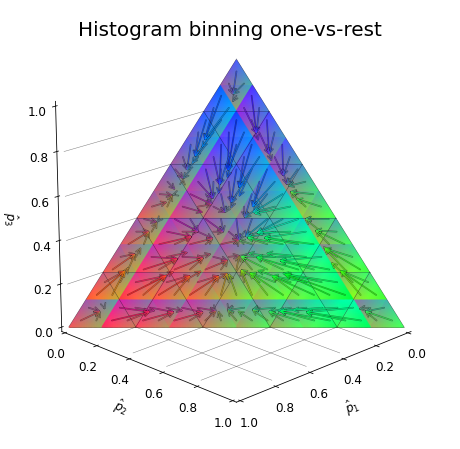

Isotonic one-vs-rest
True multiclass mean absolute CE: 0.0285309


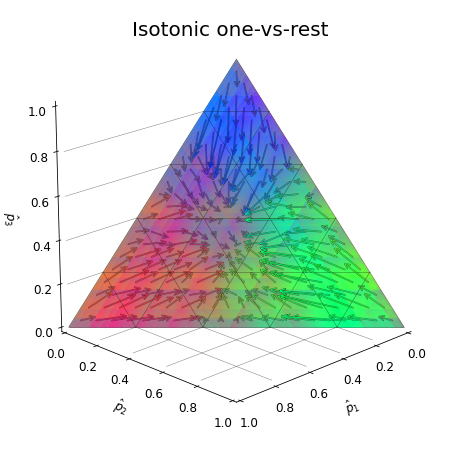

Beta one-vs-rest
True multiclass mean absolute CE: 0.0255621


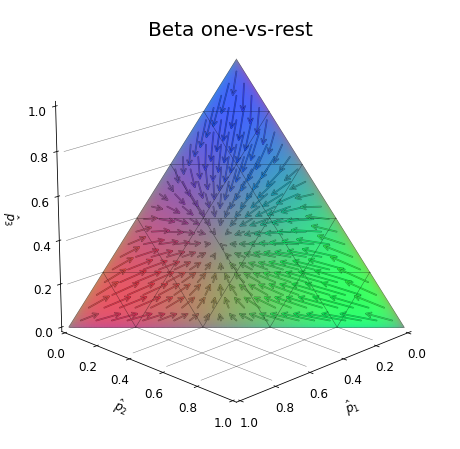

In [12]:
draw_cf_triangle(hova, dpi=figs_dpi, title="Histogram binning one-vs-rest", name="Histogram binning one-vs-rest")
draw_cf_triangle(irova, dpi=figs_dpi, title="Isotonic one-vs-rest", name="Isotonic one-vs-rest")
draw_cf_triangle(bova, dpi=figs_dpi, title="Beta one-vs-rest", name="Beta one-vs-rest")

# TempS VecS MatrixS DirS

In [13]:
ms = Dirichlet_NN(use_logits=True)
ms.fit(np.log(data_train["p"]), data_train["y"].argmax(axis=1))

def matrix_scaler(p):
    logits_p = np.log(p)
    return ms.predict(logits_p)


dir = Dirichlet_NN(use_logits=False)
dir.fit(data_train["p"], data_train["y"].argmax(axis=1))

def dir_scaler(p):
    return dir.predict(p)


ts = TemperatureScaling()
ts.fit(np.log(data_train["p"]), data_train["y"].argmax(axis=1))

def temp_scaler(p):
    logits_p = np.log(p)
    return ts.predict(logits_p)


vecs = VectorScaling()
vecs.fit(np.log(data_train["p"]), data_train["y"].argmax(axis=1))

def vec_scaler(p):
    logits_p = np.log(p)
    return vecs.predict(logits_p)

Dirichlet calibration
True multiclass mean absolute CE: 0.0149767


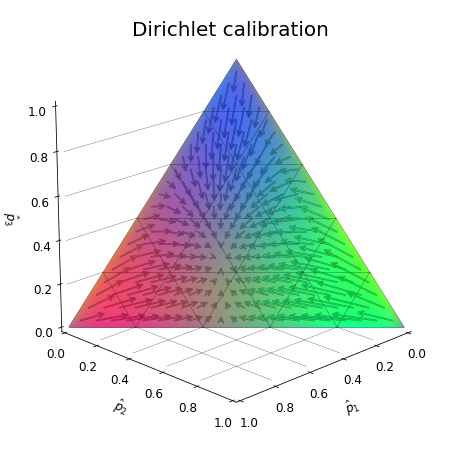

Temperature scaling
True multiclass mean absolute CE: 0.0284107


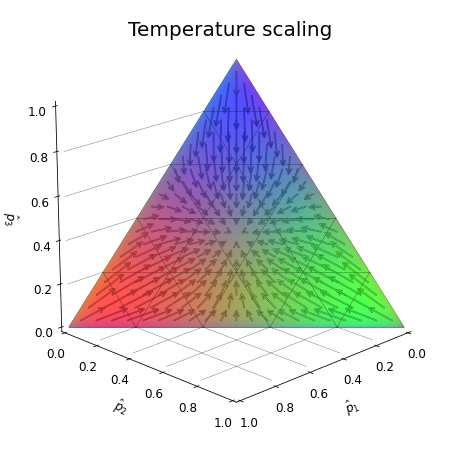

Vector scaling
True multiclass mean absolute CE: 0.0190437


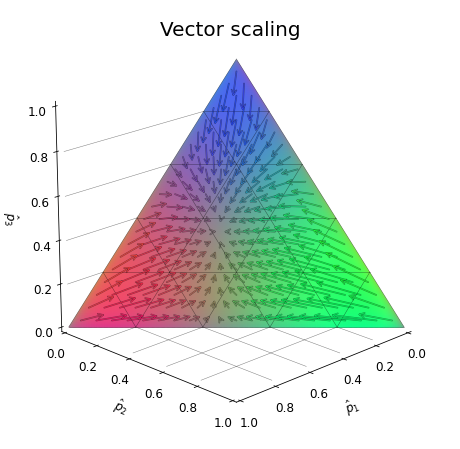

Matrix scaling
True multiclass mean absolute CE: 0.0149767


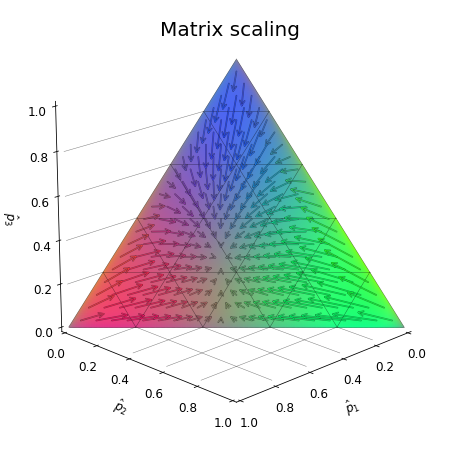

uncal
True multiclass mean absolute CE: 0.0556327


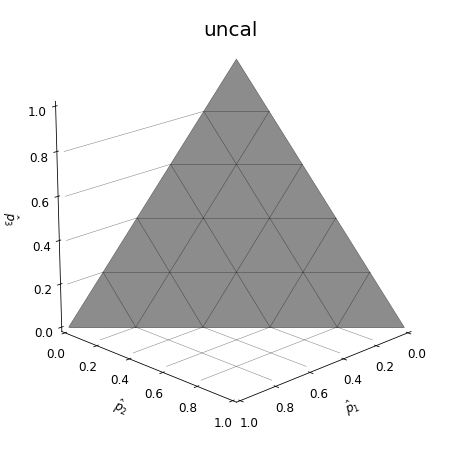

In [14]:
draw_cf_triangle(dir_scaler, "Dirichlet calibration",dpi=figs_dpi)
draw_cf_triangle(temp_scaler, "Temperature scaling",dpi=figs_dpi)
draw_cf_triangle(vec_scaler, "Vector scaling", dpi=figs_dpi)
draw_cf_triangle(matrix_scaler, "Matrix scaling",dpi=figs_dpi )
draw_cf_triangle(lambda x: x, f"uncal", f"uncal")

# IOP

LOSS: 0.8273535966873169
ITERATION: 0
LOSS: 0.8119524121284485
ITERATION: 1
LOSS: 0.8086170554161072
ITERATION: 2
LOSS: 0.8106412291526794
ITERATION: 3
LOSS: 0.8095785975456238
ITERATION: 4
LOSS: 0.8070383071899414
ITERATION: 5
LOSS: 0.8057295083999634
ITERATION: 6
LOSS: 0.8060628175735474
ITERATION: 7
LOSS: 0.8067139387130737
ITERATION: 8
LOSS: 0.806705892086029
ITERATION: 9
LOSS: 0.8060927987098694
ITERATION: 10
LOSS: 0.8052981495857239
ITERATION: 11
LOSS: 0.8047154545783997
ITERATION: 12
LOSS: 0.8045523166656494
ITERATION: 13
LOSS: 0.8046959638595581
ITERATION: 14
LOSS: 0.8049259781837463
ITERATION: 15
LOSS: 0.8050346970558167
ITERATION: 16
LOSS: 0.8049618601799011
ITERATION: 17
LOSS: 0.8047659397125244
ITERATION: 18
LOSS: 0.8045721650123596
ITERATION: 19
LOSS: 0.8044209480285645
ITERATION: 20
LOSS: 0.8043338656425476
ITERATION: 21
LOSS: 0.8043064475059509
ITERATION: 22
LOSS: 0.8043054938316345
ITERATION: 23
LOSS: 0.8042877316474915
ITERATION: 24
LOSS: 0.8042271733283997
ITERATION: 

ITERATION: 227
LOSS: 0.799071729183197
ITERATION: 228
LOSS: 0.7990697622299194
ITERATION: 229
LOSS: 0.7990371584892273
ITERATION: 230
LOSS: 0.7990365028381348
ITERATION: 231
LOSS: 0.7990398406982422
ITERATION: 232
LOSS: 0.7990268468856812
ITERATION: 233
LOSS: 0.7990211844444275
ITERATION: 234
LOSS: 0.7990022301673889
ITERATION: 235
LOSS: 0.7989974617958069
ITERATION: 236
LOSS: 0.7989882230758667
ITERATION: 237
LOSS: 0.7989790439605713
ITERATION: 238
LOSS: 0.7989646792411804
ITERATION: 239
LOSS: 0.7989680767059326
ITERATION: 240
LOSS: 0.7989633679389954
ITERATION: 241
LOSS: 0.7989702224731445
ITERATION: 242
LOSS: 0.7989558577537537
ITERATION: 243
LOSS: 0.7989546656608582
ITERATION: 244
LOSS: 0.79896479845047
ITERATION: 245
LOSS: 0.798945963382721
ITERATION: 246
LOSS: 0.7989327907562256
ITERATION: 247
LOSS: 0.7989272475242615
ITERATION: 248
LOSS: 0.7989068627357483
ITERATION: 249
IOP
True multiclass mean absolute CE: 0.0209395


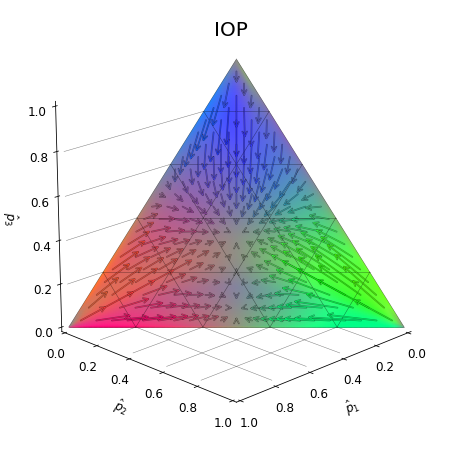

In [15]:
import json
from easydict import EasyDict
import torch
import numpy as np
import sys
sys.path.append('IntraOrderPreservingCalibration')
from IntraOrderPreservingCalibration import builder

with open("figures/syn_experiment_iop_config.json", 'r') as f:
    config = EasyDict(json.load(f))
config.cuda = False
model = builder.get_model(config.model, num_classes=3)
optimizer = builder.get_optimizer(config.optimizer, model)
loss_fn = builder.get_loss_fn(config.loss, model)

model.train()

for epoch in range(250):
    def eval():
        calibrated_logits = model(torch.from_numpy(np.log(data_train["p"]).astype(np.float32)))
        loss = loss_fn(calibrated_logits, torch.from_numpy(data_train["y"].argmax(axis=1)))
        print("LOSS: {}".format(loss))
        loss.backward()
        print("ITERATION: {}".format(epoch))
        return loss

    optimizer.zero_grad()
    optimizer.step(eval)

def cal_fun_iop(p):
    return softmax(model(torch.from_numpy(np.log(p).astype(np.float32))).detach().numpy().astype(float))

draw_cf_triangle(cal_fun_iop, title="IOP", name=f"IOP", dpi=figs_dpi)

# Calibration forest

Random calibration forest
(100 trees, 32 bins)
True multiclass mean absolute CE: 0.0222093


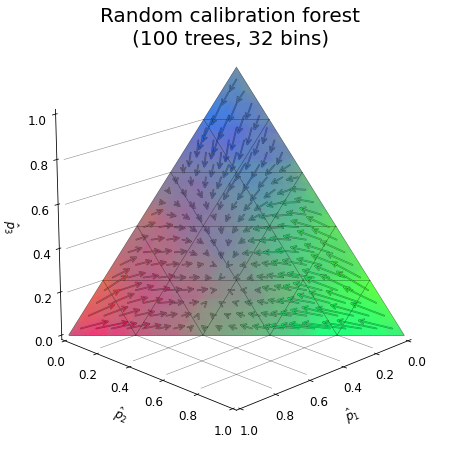

In [16]:
depth = 5
forest = RandomSplitCalibrationForest(n_trees=100, depth=depth, n_classes=3)
forest.fit(p=data_train["p"], y=data_train["y"])
draw_cf_triangle(forest.calibrate_predictions, title=f"Random calibration forest\n(100 trees, {2**depth} bins)", name=f"{2**depth}forest)", dpi=figs_dpi)

Random calibration tree
(32 bins)
True multiclass mean absolute CE: 0.0470943


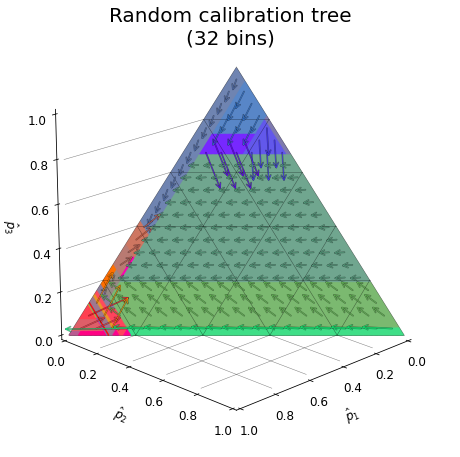

Random calibration tree
(32 bins)
True multiclass mean absolute CE: 0.038049


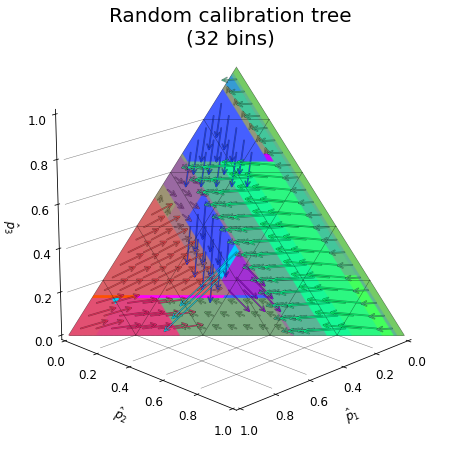

Random calibration tree
(32 bins)
True multiclass mean absolute CE: 0.0286809


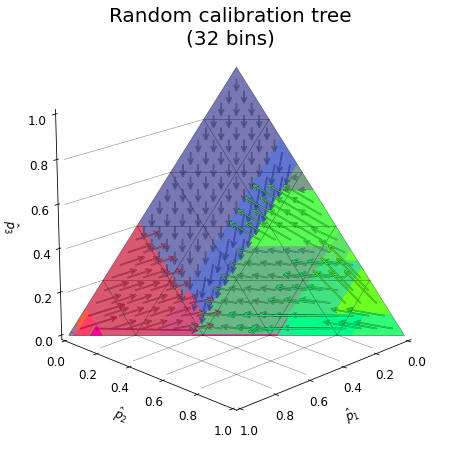

Random calibration tree
(32 bins)
True multiclass mean absolute CE: 0.036318


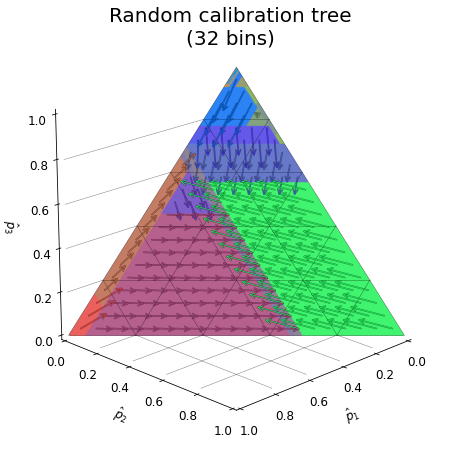

Random calibration tree
(32 bins)
True multiclass mean absolute CE: 0.0358797


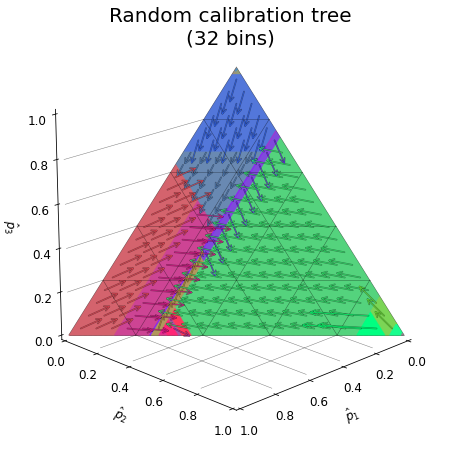

Random calibration tree
(32 bins)
True multiclass mean absolute CE: 0.0396212


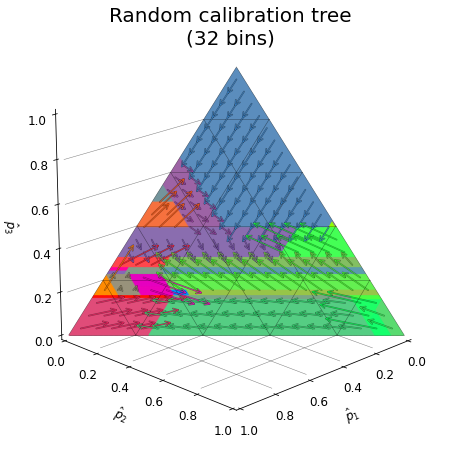

Random calibration tree
(32 bins)
True multiclass mean absolute CE: 0.0357892


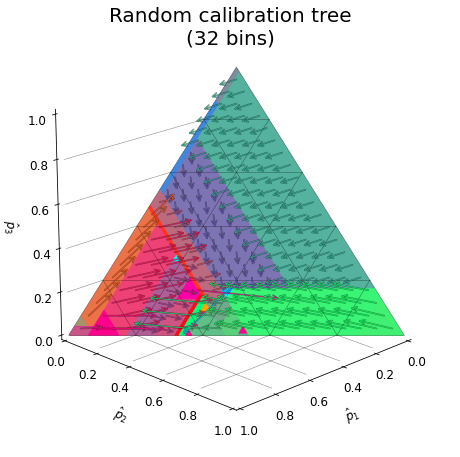

Random calibration tree
(32 bins)
True multiclass mean absolute CE: 0.0313706


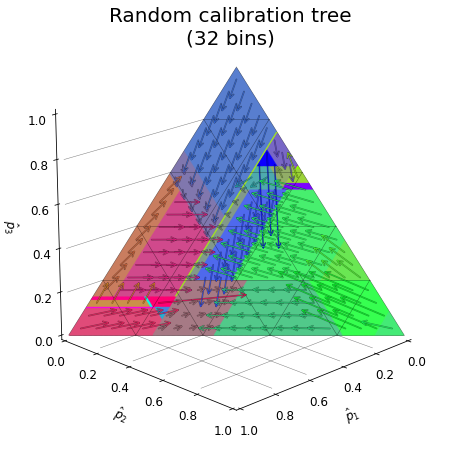

Random calibration tree
(32 bins)
True multiclass mean absolute CE: 0.0501375


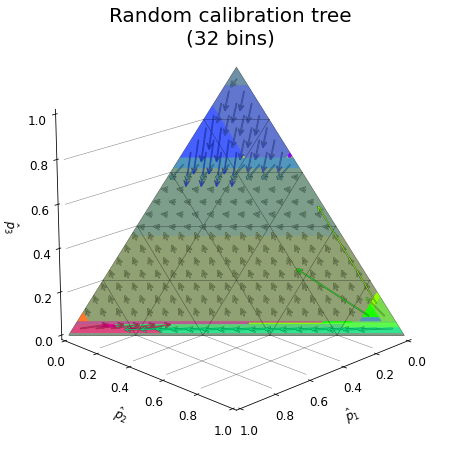

Random calibration tree
(32 bins)
True multiclass mean absolute CE: 0.0404436


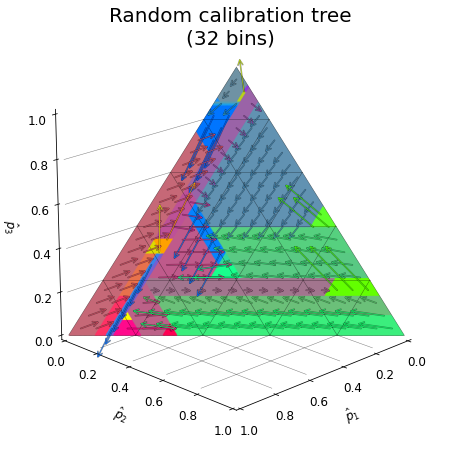

In [17]:
for tree_idx in range(0, 10):
    tree = forest.trees[tree_idx]
    draw_cf_triangle(tree.calibrate_predictions, title=f"Random calibration tree\n({2**depth} bins)", name=f"{2**depth}tree{tree_idx}", dpi=figs_dpi)

# KNN calibration

KNN calibration
k=256
True multiclass mean absolute CE: 0.0223659


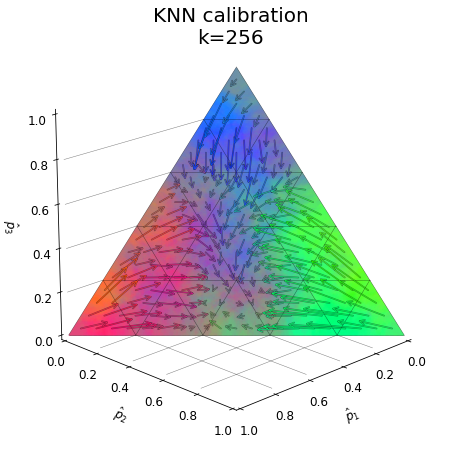

KNN calibration
k=512
True multiclass mean absolute CE: 0.0212792


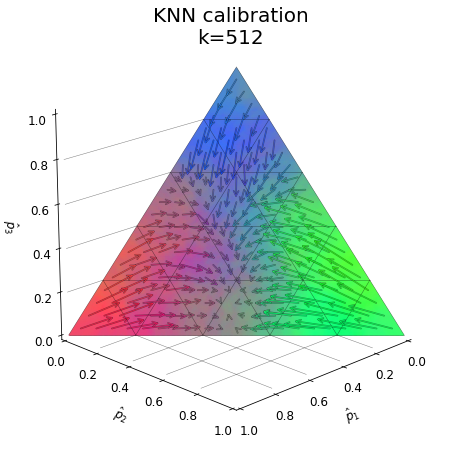

KNN calibration
k=1024
True multiclass mean absolute CE: 0.0224434


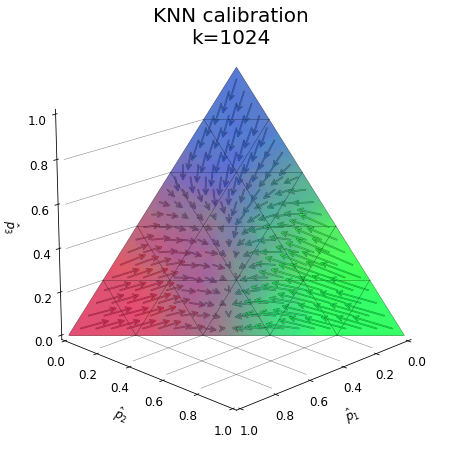

In [18]:
for k in [256, 512, 1024]:
    def knn_cal(p_test):
        return calibrate_preds_with_weighting(x_train=data_train["p"],
                                           x_test=p_test,
                                           p_train=data_train["p"],
                                           p_test=p_test,
                                           y_train=data_train["y"],
                                           weights_fun=lambda test, train: k_closest_uniform(minkowski_dist(test, train, p=2), k),
                                           batch_size=5000,
                                           crop=1e-6)
    draw_cf_triangle(knn_cal, title=f"KNN calibration\nk={k}", name=f"KNN{k}", dpi=figs_dpi)

# Kernel calibration

Kernel calibration
h=0.01
True multiclass mean absolute CE: 0.0299745


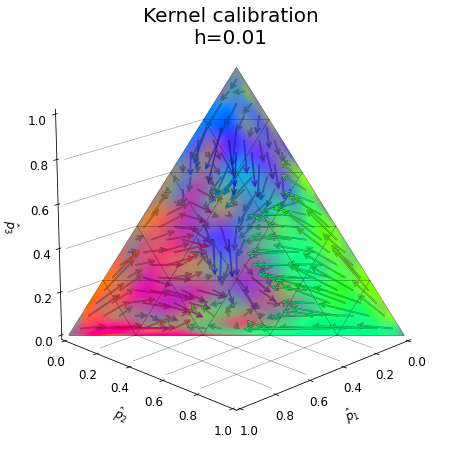

Kernel calibration
h=0.1
True multiclass mean absolute CE: 0.0143258


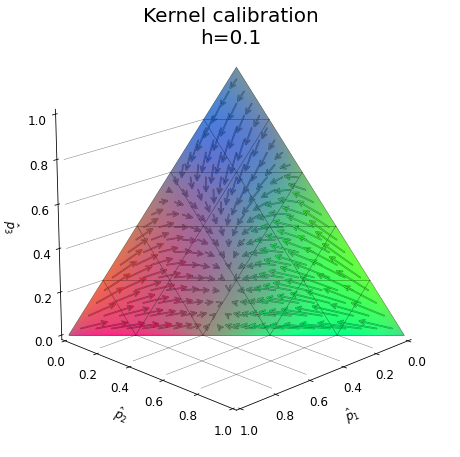

Kernel calibration
h=1
True multiclass mean absolute CE: 0.0395828


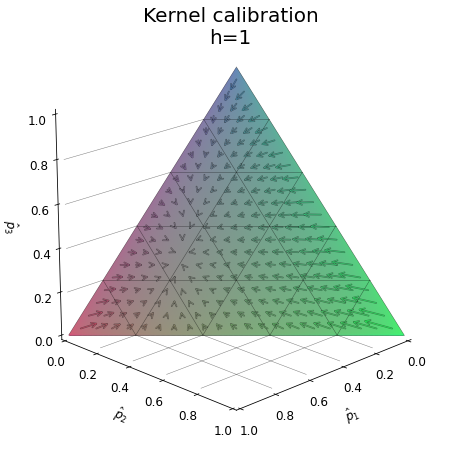

In [19]:
for g in [0.01, 0.1, 1]:

    def knn_cal(p_test):
        return calibrate_preds_with_weighting(x_train=data_train["p"],
                                           x_test=p_test,
                                           p_train=data_train["p"],
                                           p_test=p_test,
                                           y_train=data_train["y"],
                                           weights_fun=lambda test, train: proportional_to_exp_kernel(dirichlet_log_kernel(test, train, h=g)),
                                           batch_size=5000,
                                           crop=1e-6)
    draw_cf_triangle(knn_cal, title=f"Kernel calibration\nh={g}", name=f"DIR{g}", dpi=figs_dpi)

# Kernel RBF vs DIR

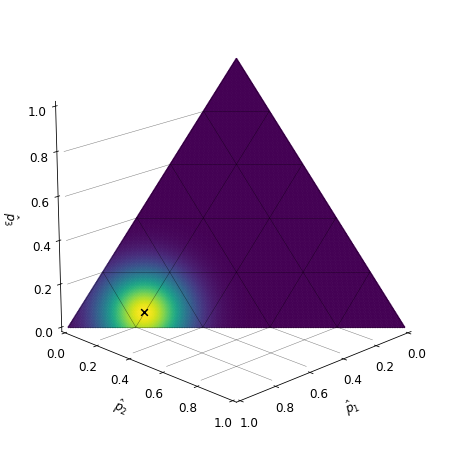

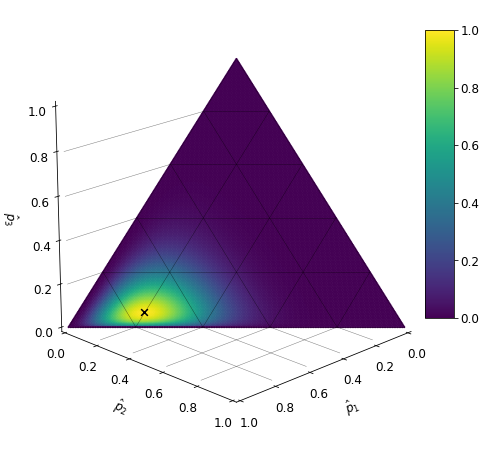

In [20]:
from scipy.special import gamma

temp = 1

p_test = generate_points_on_triangle()
p_train = np.array([[0.75, 0.2, 0.05]])

from scipy.stats import dirichlet
from sklearn.preprocessing import normalize


def dirichlet_log_kernel(x_test, x_train, h):
    all_weights = np.zeros((x_test.shape[0], x_train.shape[0]))
    x_test_precise = normalize(np.array(x_test, np.float64), norm="l1").T
    for pred_idx, pred in enumerate(x_train):
        alpha = pred / h + 1
        weights = dirichlet.logpdf(x_test_precise, alpha=alpha)
        all_weights[:, pred_idx] = weights
    return all_weights


dir_weights = np.exp(dirichlet_log_kernel(p_test, p_train,
                                          h=0.1))  # * rbf_kernel(p_test * np.array([1,4,1]), p_train * np.array([1,4,1]), gamma=10)

dir_weights = dir_weights / np.max(dir_weights)

rbf_weights = rbf_kernel(p_test, p_train, gamma=30)
titles = ["rbf", "dir"]
#plt.subplots_adjust(wspace=0, hspace=0)

for w_idx, weights in enumerate([rbf_weights, dir_weights]):
    fig = set_up_3d_fig(subplots=1)
    ax1, axis_idx = add_triangle_axis(fig, 1, 1, temp_param=temp, step=0.2)
    plot_ax_to_triangle_guidelines(ax1, step=0.2)
    plot_on_triangle_guidelines(ax1, thick_borders=False, temp_param=temp, step=0.2)

    #weights = np.exp(dirichlet_log_kernel(p_train, p_test, h=0.1)).T# * rbf_kernel(p_test * np.array([1,4,1]), p_train * np.array([1,4,1]), gamma=10)
    scatter_points = ax1.scatter(p_test[:, 0],
                                 p_test[:, 1],
                                 p_test[:, 2],
                                 alpha=1, c=weights, zorder=0, s=1.5, rasterized=True)

    ax1.scatter(p_train[:, 0] + 0.01,
                p_train[:, 1] + 0.01,
                p_train[:, 2] + 0.01,
                alpha=1, c="black", zorder=1, s=45, marker="x")

    if w_idx == 1:
        cax = fig.add_axes([0.85, 0.34, 0.05, 0.5])
        cbar = fig.colorbar(scatter_points, cax=cax, orientation="vertical")
    plt.savefig(f"figures/{titles[w_idx]}_kernel.pdf", dpi=400, bbox_inches="tight", transparent=True)
    plt.show()

# Decision calibration

In [21]:
from helpers.dec_cal import CalibratorDecision
import torch 

dec_cal = CalibratorDecision()
dec_cal.train(torch.from_numpy(data_train["p"]).to(torch.float),
              torch.from_numpy(data_train["y"].argmax(axis=1)).to(torch.int64),
              calib_steps=20, num_action=2, num_critic_epoch=1000, norm=2, 
              test_predictions=torch.from_numpy(data_train["p"]).to(torch.float),
              test_labels=torch.from_numpy(data_train["y"].argmax(axis=1)).to(torch.int64))

Loss gap train: 0.04057306796312332
Loss gap test: 0.03966182470321655
Loss gap train: 0.014882228337228298
Loss gap test: 0.014093095436692238
Loss gap train: 0.005020803771913052
Loss gap test: 0.004981003236025572
Loss gap train: 0.004133031703531742
Loss gap test: 0.004160561598837376
Loss gap train: 0.003492427757009864
Loss gap test: 0.0031838910654187202
Loss gap train: 0.0034372243098914623
Loss gap test: 0.003033250570297241
Loss gap train: 0.003054411383345723
Loss gap test: 0.0025154026225209236
Loss gap train: 0.002697855466976762
Loss gap test: 0.0026972773484885693
Loss gap train: 0.0024810421746224165
Loss gap test: 0.0029011815786361694
Loss gap train: 0.002838432090356946
Loss gap test: 0.002775707747787237
Loss gap train: 0.003106757765635848
Loss gap test: 0.003228246234357357
Loss gap train: 0.001983827678486705
Loss gap test: 0.0019326001638546586
Loss gap train: 0.0024395405780524015
Loss gap test: 0.0026363637298345566
Loss gap train: 0.0023043209221214056
Loss g

Decision calibration
(2 decisions, 1 iterations)
True multiclass mean absolute CE: 0.0396142


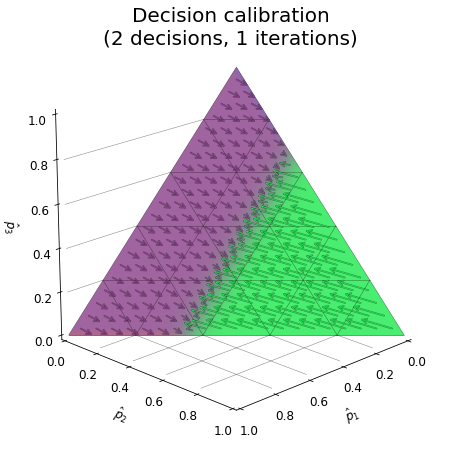

Decision calibration
(2 decisions, 2 iterations)
True multiclass mean absolute CE: 0.0288546


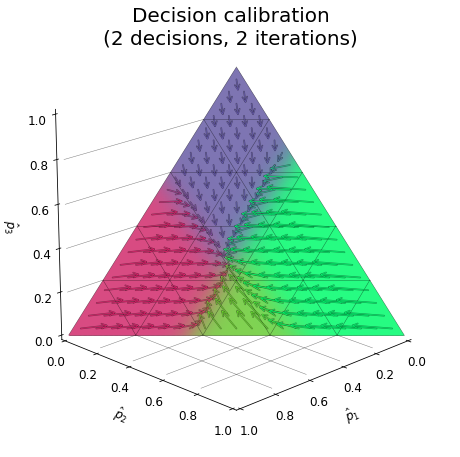

Decision calibration
(2 decisions, 3 iterations)
True multiclass mean absolute CE: 0.0294889


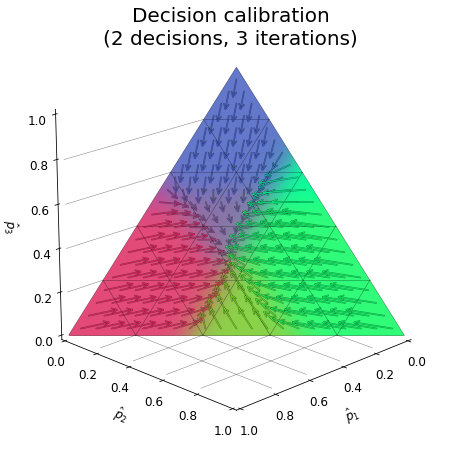

Decision calibration
(2 decisions, 4 iterations)
True multiclass mean absolute CE: 0.026136


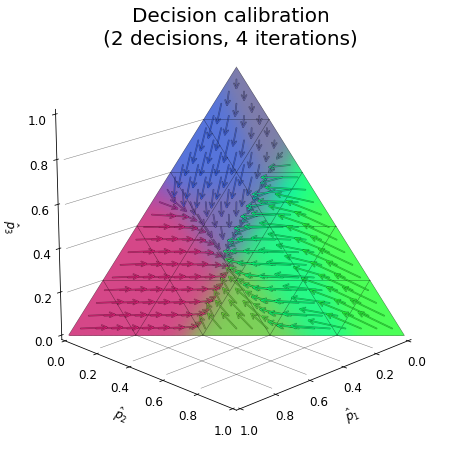

Decision calibration
(2 decisions, 5 iterations)
True multiclass mean absolute CE: 0.0248977


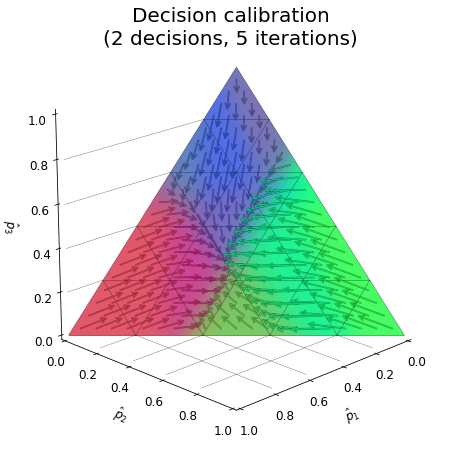

Decision calibration
(2 decisions, 6 iterations)
True multiclass mean absolute CE: 0.0240277


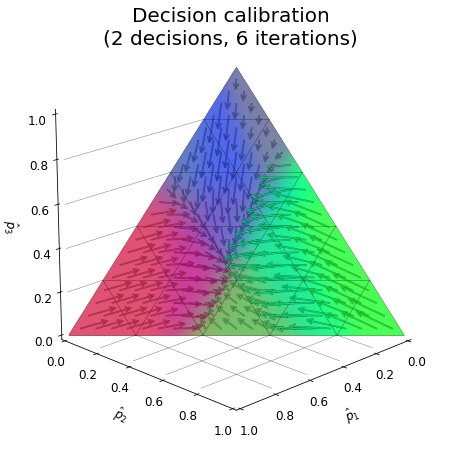

Decision calibration
(2 decisions, 7 iterations)
True multiclass mean absolute CE: 0.0237133


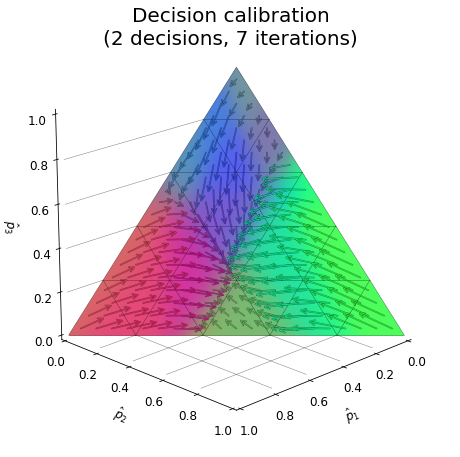

Decision calibration
(2 decisions, 8 iterations)
True multiclass mean absolute CE: 0.0219877


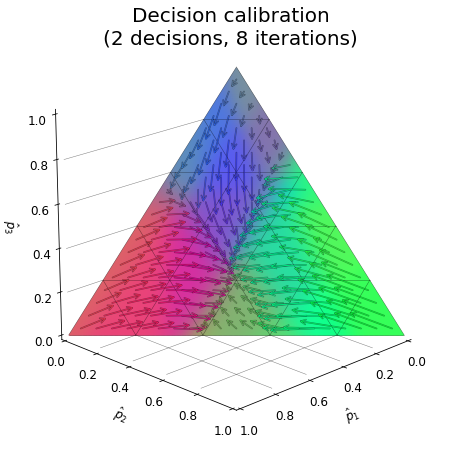

Decision calibration
(2 decisions, 9 iterations)
True multiclass mean absolute CE: 0.0222075


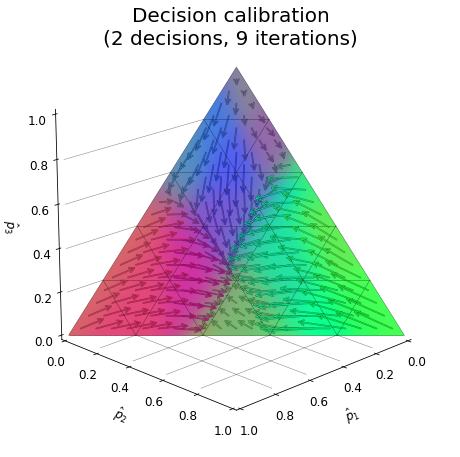

Decision calibration
(2 decisions, 10 iterations)
True multiclass mean absolute CE: 0.0234597


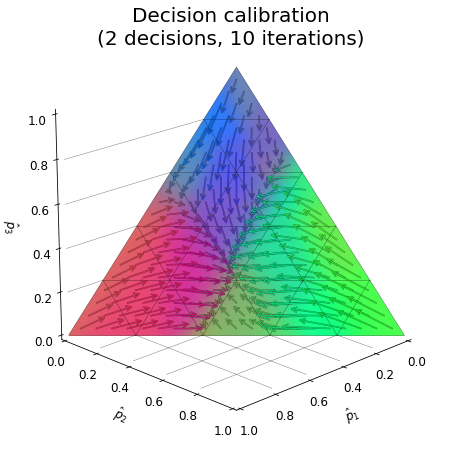

Decision calibration
(2 decisions, 11 iterations)
True multiclass mean absolute CE: 0.0217405


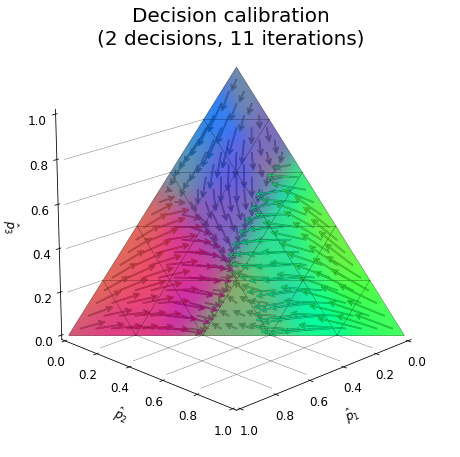

Decision calibration
(2 decisions, 12 iterations)
True multiclass mean absolute CE: 0.0218026


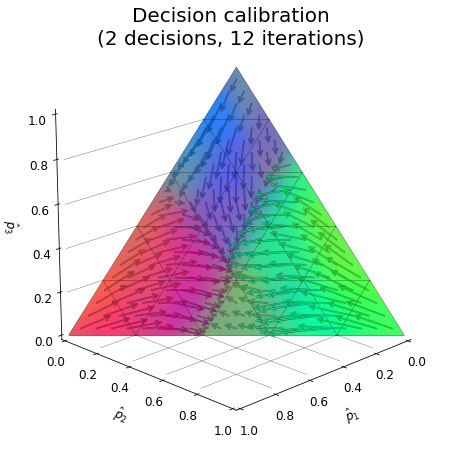

Decision calibration
(2 decisions, 13 iterations)
True multiclass mean absolute CE: 0.021361


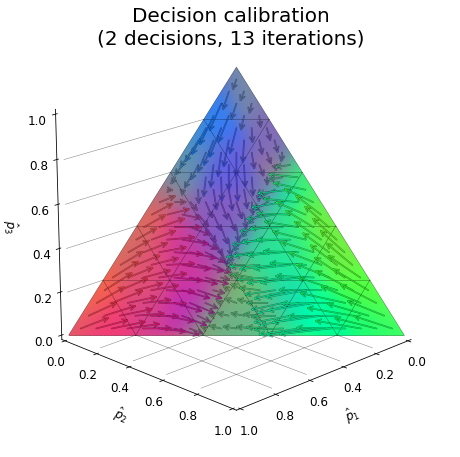

Decision calibration
(2 decisions, 14 iterations)
True multiclass mean absolute CE: 0.0215456


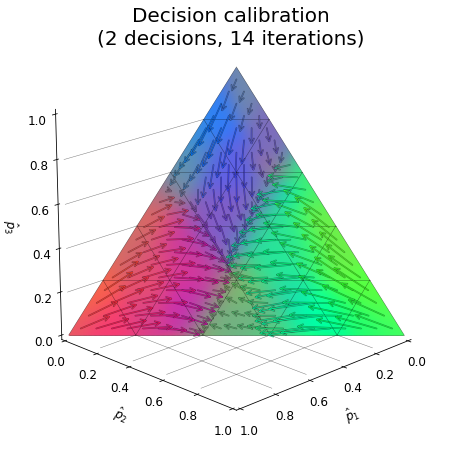

Decision calibration
(2 decisions, 15 iterations)
True multiclass mean absolute CE: 0.0219633


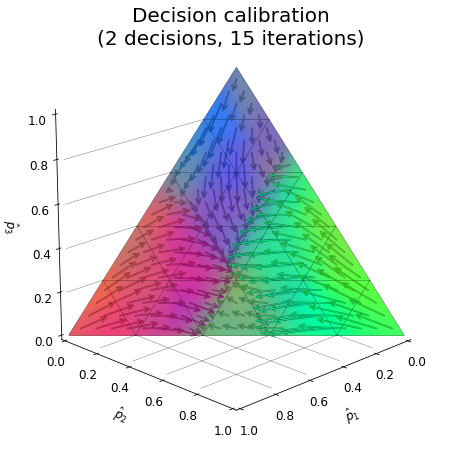

Decision calibration
(2 decisions, 16 iterations)
True multiclass mean absolute CE: 0.0217919


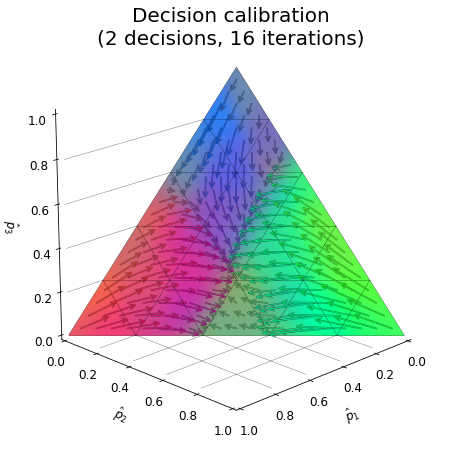

Decision calibration
(2 decisions, 17 iterations)
True multiclass mean absolute CE: 0.0219902


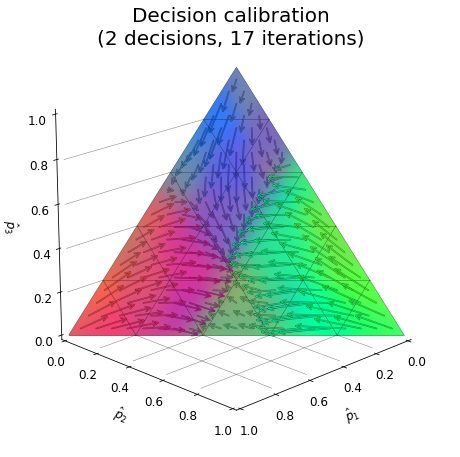

Decision calibration
(2 decisions, 18 iterations)
True multiclass mean absolute CE: 0.0214839


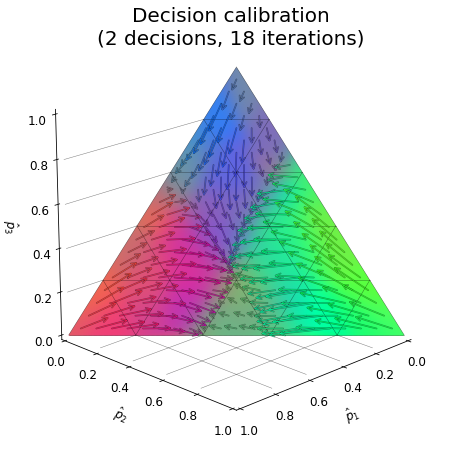

Decision calibration
(2 decisions, 19 iterations)
True multiclass mean absolute CE: 0.0225767


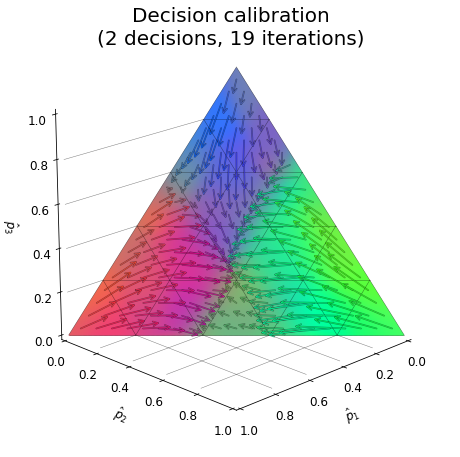

Decision calibration
(2 decisions, 20 iterations)
True multiclass mean absolute CE: 0.0225578


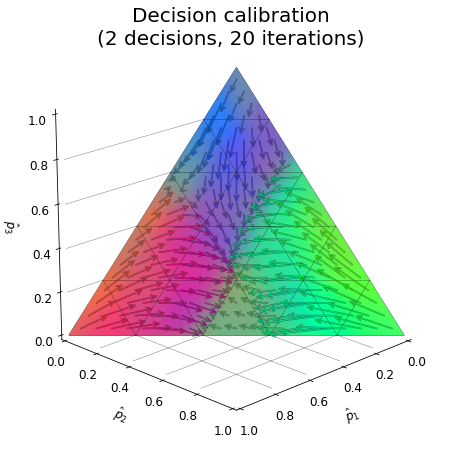

In [22]:
for i in range(1, 21):
    def dec_cal_iter(p):
        pred = np.array(dec_cal(torch.from_numpy(p).to(torch.float), max_critic=i))
        return force_p_to_simplex(pred, crop=1e-6)


    draw_cf_triangle(dec_cal_iter, f"Decision calibration\n(2 decisions, {i} iterations)", f"dec2_iter{i}", dpi=figs_dpi)

# Results table for syn exp

In [23]:
def knn_cal(p_test):
    return calibrate_preds_with_weighting(x_train=data_train["p"],
                                       x_test=p_test,
                                       p_train=data_train["p"],
                                       p_test=p_test,
                                       y_train=data_train["y"],
                                       weights_fun=lambda test, train: k_closest_uniform(minkowski_dist(test, train, p=2), 512),
                                       batch_size=5000,
                                       crop=1e-6)

def kernel_cal(p_test):
    return calibrate_preds_with_weighting(x_train=data_train["p"],
                                       x_test=p_test,
                                       p_train=data_train["p"],
                                       p_test=p_test,
                                       y_train=data_train["y"],
                                       weights_fun=lambda test, train: proportional_to_exp_kernel(dirichlet_log_kernel(test, train, h=0.1)),
                                       batch_size=5000,
                                       crop=1e-6)

def dec_cal_iter(p):
    pred = np.array(dec_cal(torch.from_numpy(p).to(torch.float), max_critic=10))
    return force_p_to_simplex(pred, crop=1e-6)

def uncal(p):
    return p
funs = {"uncal":uncal,
        "true_cal_fun":true_cal_fun,
        "iop":cal_fun_iop,
        "hova":hova,
        "irova":irova,
        "bova":bova,
        "dir":dir_scaler, "ts":temp_scaler, "vs":vec_scaler,
        "forest":forest.calibrate_predictions,
        "knn":knn_cal, "kernel":kernel_cal,
        "dec":dec_cal_iter
        }

In [24]:
from helpers.optimal_decisions import generate_normal_cost_matrices, true_loss_predicted_loss
results_ll = []
results_bs = []
results_acc = []
results_gap = []
results_cw_ce = []
results_cf_ce = []

n_matrices = 500
cost_matrices2 = generate_normal_cost_matrices(n_classes=3, n_decisions=2, n_matrices=n_matrices, seed=0, mean=0, std=1)

for fun_name, fun in funs.items():
    print(fun_name)
    cal_p_test = fun(data_test["p"])

    results_ll.append(log_loss(data_test["y"], cal_p_test))
    results_bs.append(bs(data_test["y"], cal_p_test))
    results_acc.append(np.mean(data_test["y"].argmax(axis=1) == cal_p_test.argmax(axis=1)))
    results_cw_ce.append(np.mean(np.abs(cal_p_test - data_test['c'])))
    results_cf_ce.append(np.mean(np.abs(cal_p_test.max(axis=1) - data_test['c'].max(axis=1))))

    true_loss, pred_loss = true_loss_predicted_loss(cal_p_test, data_test["c"], cost_matrices2)
    results_gap.append(np.mean(np.mean(np.abs(true_loss - pred_loss))))

uncal
true_cal_fun
iop
hova
irova
bova
dir
ts
vs
forest
knn
kernel
dec


In [25]:
import pandas as pd
from helpers.generate_stats_df_from_results import add_ranks_to_df, df_to_latex
selection = ["uncal", "ts", "dir", "iop", "dec", "forest", "knn", "kernel"]

df_1 = pd.DataFrame(data=[results_cf_ce, results_cw_ce, results_bs, results_ll],
                  columns=funs.keys(),
                  index=["confidence CE", "classwise CE", "Brier score", "log-loss"]).round(3)[selection]
df_2 = pd.DataFrame(data=[results_acc],
                  columns=funs.keys(),
                  index=["accuracy"]).round(3)[selection]
df_3 = pd.DataFrame(data=[results_gap],
                  columns=funs.keys(),
                  index=["average loss gap"]).round(3)[selection]

df_1_ranks = df_1.rank(ascending=True, axis=1)
df_2_ranks = df_2.rank(ascending=False, axis=1, method="first")
df_3_ranks = df_3.rank(ascending=True, axis=1)
df_1 = add_ranks_to_df(df_1, ascending=True)
df_2 = add_ranks_to_df(df_2, ascending=False)
df_3 = add_ranks_to_df(df_3, ascending=True)
df_3.loc[("average rank"),:] = np.round(df_1_ranks.append(df_2_ranks).append(df_3_ranks).mean(), 1)

selection = ["true_cal_fun"]
df_1tr = pd.DataFrame(data=[results_cf_ce, results_cw_ce, results_bs, results_ll],
                  columns=funs.keys(),
                  index=["confidence CE", "classwise CE", "Brier score", "log-loss"]).round(3)[selection]
df_2tr = pd.DataFrame(data=[results_acc],
                  columns=funs.keys(),
                  index=["accuracy"]).round(3)[selection]
df_3tr = pd.DataFrame(data=[results_gap],
                  columns=funs.keys(),
                  index=["average loss gap"]).round(3)[selection]

pd.options.display.float_format = '{:,.3f}'.format

df = pd.DataFrame()
df = df.append(df_1).append(df_2).append(df_3)
df[selection] = df_1tr.append(df_2tr).append(df_3tr)
print(df_to_latex(df))
df

\begin{tabular}{lllllllllr}
\toprule
{} &        uncal &           ts &                   dir &          iop &          dec &       forest &          knn &                kernel &  true_cal_fun \\
\midrule
confidence CE    &  $0.079_{8}$ &  $0.031_{7}$ &           $0.019_{2}$ &  $0.024_{3}$ &  $0.024_{3}$ &  $0.028_{6}$ &  $0.025_{5}$ &  $\mathbf{0.017_{1}}$ &         0.000 \\
classwise CE     &  $0.056_{8}$ &  $0.028_{7}$ &           $0.015_{2}$ &  $0.021_{3}$ &  $0.023_{6}$ &  $0.022_{5}$ &  $0.021_{3}$ &  $\mathbf{0.014_{1}}$ &         0.000 \\
Brier score      &  $0.492_{8}$ &  $0.481_{7}$ &           $0.478_{1}$ &  $0.479_{4}$ &  $0.479_{4}$ &  $0.479_{4}$ &  $0.479_{4}$ &           $0.478_{1}$ &         0.476 \\
log-loss         &  $0.826_{8}$ &  $0.798_{7}$ &           $0.793_{2}$ &  $0.794_{3}$ &  $0.797_{6}$ &  $0.794_{3}$ &  $0.796_{5}$ &  $\mathbf{0.791_{1}}$ &         0.788 \\
accuracy         &  $0.625_{7}$ &  $0.625_{7}$ &  $\mathbf{0.628_{1}}$ &  $0.625_{7}$ &  $0.627_{2

uncal           ts                   dir          iop  \
confidence CE     $0.079_{8}$  $0.031_{7}$           $0.019_{2}$  $0.024_{3}$   
classwise CE      $0.056_{8}$  $0.028_{7}$           $0.015_{2}$  $0.021_{3}$   
Brier score       $0.492_{8}$  $0.481_{7}$           $0.478_{1}$  $0.479_{4}$   
log-loss          $0.826_{8}$  $0.798_{7}$           $0.793_{2}$  $0.794_{3}$   
accuracy          $0.625_{7}$  $0.625_{7}$  $\mathbf{0.628_{1}}$  $0.625_{7}$   
average loss gap  $0.037_{8}$  $0.015_{7}$            $0.01_{3}$  $0.009_{1}$   
average rank            7.700        7.000                 1.900        4.100   

                          dec       forest          knn                kernel  \
confidence CE     $0.024_{3}$  $0.028_{6}$  $0.025_{5}$  $\mathbf{0.017_{1}}$   
classwise CE      $0.023_{6}$  $0.022_{5}$  $0.021_{3}$  $\mathbf{0.014_{1}}$   
Brier score       $0.479_{4}$  $0.479_{4}$  $0.479_{4}$           $0.478_{1}$   
log-loss          $0.797_{6}$  $0.794_{3}$  $0.796_{5}$  $\mathbf{0.791_{1}}$   
accuracy          $0.627_{2}$  $0.626_{4}$  $0.626_{4}$           $0.626_{4}$   
average loss gap  $0.012_{5}$  $0.012_{5}$  $0.012_{5}$           $0.009_{1}$   
average rank            4.500        4.500        4.500                 1.800   

                  true_cal_fun  
confidence CE            0.000  
classwise CE             0.000  
Brier score              0.476  
log-loss                 0.788  
accuracy                 0.627  
average loss gap         0.000  
average rank               nan